<a href="https://colab.research.google.com/github/EricSiq/Crime_In_India_Insights/blob/main/UML_IndiaCrimeAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages Used

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Data Loading


In [43]:

file_path= 'crime_dataset_india.csv'

try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully!\n")
    print("Size of dataset (rows , columns) is:",df.shape)

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully!

Size of dataset (rows , columns) is: (40160, 14)


Dataset is 14 columns into 40160 rows = 562,240 data entries large.

It faces several formatting issues which need to be resolved.

 Especially, in the columns with 'date:month:year time' data values.

In [44]:

df.head(10)

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Report Number,Date Reported,Date of Occurrence,Time of Occurrence,City,Crime Code,Crime Description,Victim Age,Victim Gender,Weapon Used,Crime Domain,Police Deployed,Case Closed,Date Case Closed
0,1,02/01/2020 00:00,01/01/2020 00:00,01/01/2020 01:11,Ahmedabad,576,IDENTITY THEFT,16,M,Blunt Object,Violent Crime,13,No,NaN
1,2,01/01/2020 19:00,01/01/2020 01:00,01/01/2020 06:26,Chennai,128,HOMICIDE,37,M,Poison,Other Crime,9,No,NaN
2,3,02/01/2020 05:00,01/01/2020 02:00,01/01/2020 14:30,Ludhiana,271,KIDNAPPING,48,F,Blunt Object,Other Crime,15,No,NaN
3,4,01/01/2020 05:00,01/01/2020 03:00,01/01/2020 14:46,Pune,170,BURGLARY,49,F,Firearm,Other Crime,1,Yes,29/04/2020 05:00
4,5,01/01/2020 21:00,01/01/2020 04:00,01/01/2020 16:51,Pune,421,VANDALISM,30,F,Other,Other Crime,18,Yes,08/01/2020 21:00
5,6,02/01/2020 03:00,01/01/2020 05:00,01/01/2020 17:09,Delhi,442,ASSAULT,16,M,Firearm,Violent Crime,18,Yes,30/03/2020 03:00
6,7,01/01/2020 16:00,01/01/2020 06:00,01/01/2020 14:08,Chennai,172,VEHICLE - STOLEN,64,F,Knife,Violent Crime,13,Yes,24/03/2020 16:00
7,8,02/01/2020 10:00,01/01/2020 07:00,02/01/2020 06:33,Chennai,169,COUNTERFEITING,78,X,Knife,Other Crime,8,No,NaN
8,9,04/01/2020 03:00,01/01/2020 08:00,02/01/2020 06:34,Mumbai,338,EXTORTION,41,X,Blunt Object,Other Crime,1,No,NaN
9,10,03/01/2020 07:00,01/01/2020 09:00,01/01/2020 17:50,Chennai,497,PUBLIC INTOXICATION,29,M,Knife,Other Crime,4,No,NaN


In [54]:
# Check for missing values and count them for each column
missing_values = df.isnull().sum()

# Display the results
missing_values


,0
Report Number,0
Date Reported,0
Date of Occurrence,0
Time of Occurrence,0
City,0
Crime Code,0
Crime Description,0
Victim Age,0
Victim Gender,0
Weapon Used,5790


# Data Cleaning & Preprocessing


In [46]:

def safe_convert_datetime(value, col_name, idx, fmt='%d/%m/%Y %H:%M'):
    """
    Attempts to convert a single value to a datetime using the specified format.
    If conversion fails, returns the row index and column values as the error message,
    """
    try:
        return pd.to_datetime(value, format=fmt)
    except Exception as e:
        print(f"Error at row {idx}, column '{col_name}': {e}")
        return pd.NaT

def fix_date_of_occurrence(date_str):
    """
    Fixing date formatting for  'Date of Occurrence' column.

    Initially, occurence date is in month-day-year format ("01/13/2020 00:00")
    fucntion converts it to day-month-year format ("13/01/2020 00:00").
    """
    try:
        # Replace any dashes with slashes for consistency
        date_str_standard = date_str.replace('-', '/')
        # Parse the date using month-day-year format
        dt = pd.to_datetime(date_str_standard, format="%m/%d/%Y %H:%M", errors='raise')
        # Return the formatted string in day-month-year format
        return dt.strftime("%d/%m/%Y %H:%M")
    except Exception as e:
        print(f"Error converting date '{date_str}': {e}")
        return date_str  # Return original string if conversion fails


In [47]:
# Define a dictionary for the columns that are  in day-month-year format
# excluding 'Date of Occurrence' since it needs special handling
datetime_columns = {
    'Date Reported': '%d/%m/%Y %H:%M',
    'Time of Occurrence': '%d/%m/%Y %H:%M',
    'Date Case Closed': '%d/%m/%Y %H:%M'
}

# Use safe conversion on each column; errors are reported, to show row indices.
for col, fmt in datetime_columns.items():
    if col in df.columns:
        df[col] = df.apply(lambda row: safe_convert_datetime(row[col], col, row.name, fmt=fmt), axis=1)
    else:
        print(f"Column '{col}' not found in DataFrame.")

#Fixing the 'Date of Occurrence' column with the seperate function.
if 'Date of Occurrence' in df.columns:
    df['Date of Occurrence'] = df['Date of Occurrence'].apply(fix_date_of_occurrence)
else:
    print("Column 'Date of Occurrence' not found in DataFrame.")

#for uniformity, convert datetime columns to a string format.
desired_format = "%d/%m/%Y %H:%M"
for col in datetime_columns.keys():
    if col in df.columns:
        # Only format if the column is a datetime object (i.e. not already a string)
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].dt.strftime(desired_format)



In [48]:
# Standardize city names (convert to lowercase and remove spaces)
try:
    df['City'] = df['City'].str.lower().str.strip()
except Exception as e:
    print(f"Error processing 'City' column: {e}")


# Convert the 'Case Closed' column to boolean vals('Yes' as True and 'No' as False)
try:
    df['Case Closed'] = df['Case Closed'].map({'Yes': True, 'No': False})
except Exception as e:
    print(f"Error processing 'Case Closed' column: {e}")


#Save Cleaned DataFrame
try:
    df.to_csv('cleaned_crime_dataset_india.csv', index=False)
    crime_data=pd.read_csv('cleaned_crime_dataset_india.csv')
    print("Cleaned data saved to 'cleaned_crime_dataset_india.csv'")
except Exception as e:
    print(f"Error while saving the CSV file: {e}")


Cleaned data saved to 'cleaned_crime_dataset_india.csv'


In [50]:
print("Size of cleaned dataset (rows, columns):", crime_data.shape)

# Check for missing values
missing_values = crime_data.isnull().sum()
print("\nMissing Values per column:\n", missing_values)


Size of cleaned dataset (rows, columns): (40160, 14)

Missing Values per column:
 Report Number             0
Date Reported             0
Date of Occurrence        0
Time of Occurrence        0
City                      0
Crime Code                0
Crime Description         0
Victim Age                0
Victim Gender             0
Weapon Used            5790
Crime Domain              0
Police Deployed           0
Case Closed               0
Date Case Closed      20098
dtype: int64


In [52]:
crime_data['Date Reported'] = pd.to_datetime(crime_data['Date Reported'], format='mixed', dayfirst=True)
crime_data['Date of Occurrence'] = pd.to_datetime(crime_data['Date of Occurrence'],format='mixed', dayfirst=True)
crime_data['Date Case Closed'] = pd.to_datetime(crime_data['Date Case Closed'],format='mixed', dayfirst=True)
crime_data.head()

,Report Number,Date Reported,Date of Occurrence,Time of Occurrence,City,Crime Code,Crime Description,Victim Age,Victim Gender,Weapon Used,Crime Domain,Police Deployed,Case Closed,Date Case Closed
0,1,2020-01-02 00:00:00,2020-01-01 00:00:00,01/01/2020 01:11,ahmedabad,576,IDENTITY THEFT,16,M,Blunt Object,Violent Crime,13,False,NaT
1,2,2020-01-01 19:00:00,2020-01-01 01:00:00,01/01/2020 06:26,chennai,128,HOMICIDE,37,M,Poison,Other Crime,9,False,NaT
2,3,2020-01-02 05:00:00,2020-01-01 02:00:00,01/01/2020 14:30,ludhiana,271,KIDNAPPING,48,F,Blunt Object,Other Crime,15,False,NaT
3,4,2020-01-01 05:00:00,2020-01-01 03:00:00,01/01/2020 14:46,pune,170,BURGLARY,49,F,Firearm,Other Crime,1,True,2020-04-29 05:00:00
4,5,2020-01-01 21:00:00,2020-01-01 04:00:00,01/01/2020 16:51,pune,421,VANDALISM,30,F,Other,Other Crime,18,True,2020-01-08 21:00:00


In [57]:
# For this demonstration we select numeric columns as features.
# Here we assume that "Crime Code" and "Victim Age" are numeric features.
# We use "Case Closed" as a label. Adjust these as necessary for your data.

try:
    # Ensure numeric columns are properly converted
    X = crime_data[['Crime Code', 'Victim Age']].astype(float)
except Exception as e:
    print("Error selecting or converting feature columns:", e)

try:
    # Encode labels: convert boolean or categorical "Case Closed" into numeric labels
    # If "Case Closed" is already boolean, this will convert True/False to 1/0.
    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(crime_data["Case Closed"].astype(str))
except Exception as e:
    print("Error encoding labels:", e)

# Handle missing values in X
try:
    X.fillna(X.mean(), inplace=True)
except Exception as e:
    print("Error handling missing values in features:", e)

# Standardize the feature data
try:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
except Exception as e:
    print("Error standardizing the data:", e)


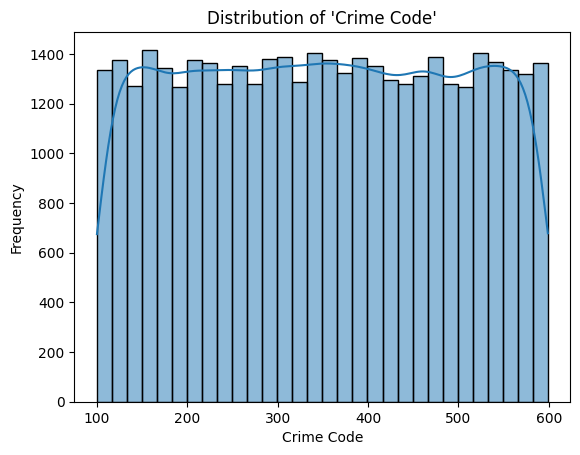

Feature Matrix Shape (X_scaled): (40160, 2)
Labels Shape (Y): 40160


In [58]:

# Optional: Exploratory Data Analysis (EDA)
try:
    sns.histplot(X.iloc[:, 0], bins=30, kde=True)
    plt.title("Distribution of 'Crime Code'")
    plt.xlabel("Crime Code")
    plt.ylabel("Frequency")
    plt.show()
except Exception as e:
    print("Error during EDA plotting:", e)

print(f"Feature Matrix Shape (X_scaled): {X_scaled.shape}")
print(f"Labels Shape (Y): {len(Y)}")


# Diemensionality Reduction

In [ ]:

# Apply Dimensionality Reduction Techniques


# PCA
try:
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_pca = pca.explained_variance_ratio_

    print("\nPCA (Principal Component Analysis):")
    for i in range(min(5, len(explained_variance_pca))):
        print(f"Component {i+1}: {explained_variance_pca[i]*100:.2f}% variance explained")
except Exception as e:
    print("Error during PCA:", e)

# LDA (works only if number of samples > number of classes)
try:
    num_classes = len(np.unique(Y))
    num_samples = X_scaled.shape[0]
    if num_samples > num_classes:
        lda = LinearDiscriminantAnalysis()
        X_lda = lda.fit_transform(X_scaled, Y)
        explained_variance_lda = lda.explained_variance_ratio_
        print("\nLDA (Linear Discriminant Analysis):")
        for i in range(len(explained_variance_lda)):
            print(f"Component {i+1}: {explained_variance_lda[i]*100:.2f}% variance explained")
    else:
        print("\nWarning: Not enough samples compared to classes. Skipping LDA.")
except Exception as e:
    print("Error during LDA:", e)

# SVD (Singular Value Decomposition)
try:
    n_components_svd = min(3, X_scaled.shape[1])
    svd = TruncatedSVD(n_components=n_components_svd)
    X_svd = svd.fit_transform(X_scaled)
    explained_variance_svd = svd.explained_variance_ratio_

    print("\nSVD (Singular Value Decomposition):")
    for i in range(len(explained_variance_svd)):
        print(f"Component {i+1}: {explained_variance_svd[i]*100:.2f}% variance explained")
except Exception as e:
    print("Error during SVD:", e)

# t-SNE
try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_scaled)
    print("\nt-SNE transformation completed.")
except Exception as e:
    print("Error during t-SNE:", e)

# MDS
try:
    mds = MDS(n_components=2, random_state=42)
    X_mds = mds.fit_transform(X_scaled)
    print("\nMDS transformation completed.")
except Exception as e:
    print("Error during MDS:", e)

print("\nDimensionality Reduction Completed!")


PCA (Principal Component Analysis):
Component 1: 50.26% variance explained
Component 2: 49.74% variance explained

LDA (Linear Discriminant Analysis):
Component 1: 100.00% variance explained

SVD (Singular Value Decomposition):
Component 1: 50.26% variance explained
Component 2: 49.74% variance explained

t-SNE transformation completed.
